# Comparing Two Samples: A/B testing

In modern data analytics, deciding whether two numerical samples come from the same underlying distribution is called A/B testing.

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels as sms


# Difference in Population Proportions

### From a technical test interview

| Action | Price A | Price B |
| --- | --- | ----------- |
| Buy | 200 | 182 |
| No buy | 23539 | 22406 |


Does the difference in the conversion rate from both price significant? 

In [162]:
CR_A=200/(23539+200)*100
CR_B=182/(22406+182)*100

print('Conversion rate price A: %s.  Conversion rate price B: %s'%(CR_A,CR_B))
print('Difference conversion rate %s'%(CR_A-CR_B))


Conversion rate price A: 0.8424954715868402.  Conversion rate price B: 0.8057375597662475
Difference conversion rate 0.03675791182059274


***Null hypothesis (H0):*** There is no difference between the price A and B

***Alternative hypothesis:*** The difference of conversion rate between price A and B is stastically significant

In [163]:
Total_buy=200+182
Toal_nobuy=23539+22406
Total_A=200+23539
Total_B=182+22406
Total=Total_A+Total_B
print(Total_A,Total_B,Total)

23739 22588 46327


In [164]:
n1 = Total_A
p1 = CR_A/100

n2 = Total_B
p2 = CR_B/100

tt=[]
for i in range(5000):
    population1 = np.random.binomial(1, p1, n1)
    population2 = np.random.binomial(1, p2, n2)

    tt.append(sm.stats.ttest_ind(population1, population2)[1])



In [165]:
np.mean(tt)

0.4675574429629131

**Conclusion of the hypothesis test**

Since the p-value (0.47) is higher than the standard confidence level 0.05, we cannot reject the Null hypothesis. The difference is not « statistically significant ».

From those number we create a dataframe to do a boostraap

In [166]:
df = pd.DataFrame(columns=['price','buy'])

In [167]:
# price column
price = ['A'] * Total_A + ['B'] * Total_B

# buy
buy_A = [1] * 200 + [0] * 23539
buy_B = [1] * 182 + [0] * 22406
buy=buy_A+buy_B
df = pd.DataFrame({'price': price, 'buy': buy})
print(df)

      price  buy
0         A    1
1         A    1
2         A    1
3         A    1
4         A    1
...     ...  ...
46322     B    0
46323     B    0
46324     B    0
46325     B    0
46326     B    0

[46327 rows x 2 columns]


In [168]:
df.groupby('price')['buy'].mean().reset_index(name='Buy average')


,price,Buy average
0,A,0.008425
1,B,0.008057


We recover the good CR for both price.

In [75]:
def difference_of_means(df, label, group_label):
    reduced = df[[label, group_label]]
    means_table = reduced.groupby(group_label).mean()
    means = means_table[label]
    return means.iloc[0] - means.iloc[1]

observed_diff = difference_of_means(df, 'buy', 'price')
observed_diff

0.0003675791182059275

We recover the same difference of CR_A-CR_B so this function is correct. To see how the statistic should vary under the null hypothesis, we have to figure out how to simulate the statistic under that hypothesis. A clever method based on random permutations does just that.

The idea, is to shuffle all the labels randomly among the price

In [76]:
def one_simulated_difference(df, label, group_label):
    shuffled_labels = df.sample(frac=1, replace=False, ignore_index=True)[group_label]
    shuffled_table = pd.DataFrame()
    shuffled_table[label] = df[label]
    shuffled_table['Shuffled Label'] = shuffled_labels
    return difference_of_means(shuffled_table, label, 'Shuffled Label')

In [77]:
simulated_diffs = np.array([])

for i in np.arange(10000):
    sim_diff = one_simulated_difference(df, 'buy', 'price')
    simulated_diffs = np.append(simulated_diffs, sim_diff)

Observed Difference: 0.0003675791182059275


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

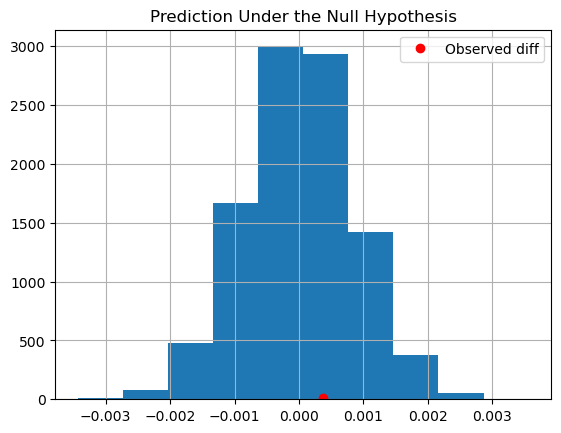

In [78]:
df = pd.DataFrame()
df['Difference Between Group Means'] = simulated_diffs
df.hist()
plt.plot(observed_diff, 10, 'ro',label='Observed diff')                 # Additional point
print('Observed Difference:', observed_diff)
plt.legend()
plt.title('Prediction Under the Null Hypothesis')

In [79]:
# p-value
pval=sum(simulated_diffs >= observed_diff)/len(simulated_diffs)
print('P-value is: %0.2f'%pval)

P-value is: 0.36


In [84]:
alpha=0.05
# interpret via p-value
if pval > alpha:
 print('We do not reject the null hypothesis, the difference between price A and B is not statistically significant.')
else:
 print('Reject the null hypothesis.')


We do not reject the null hypothesis, the difference between price A and B is not statistically significant.


# Difference in Population Means: step by step 

The table births contains the following variables for 1,174 mother-baby pairs: 
the baby’s birth weight in ounces, the number of gestational days, the mother’s age in completed years, 
the mother’s height in inches, pregnancy weight in pounds, and whether or not the mother smoked during pregnancy.


In [86]:
births = pd.read_csv('data/baby.csv')
births

,Birth Weight,Gestational Days,Maternal Age,Maternal Height,Maternal Pregnancy Weight,Maternal Smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


In [87]:
smoking_and_birthweight = births[['Maternal Smoker', 'Birth Weight']]
smoking_and_birthweight.groupby('Maternal Smoker').count()


,Birth Weight
Maternal Smoker,
False,715
True,459


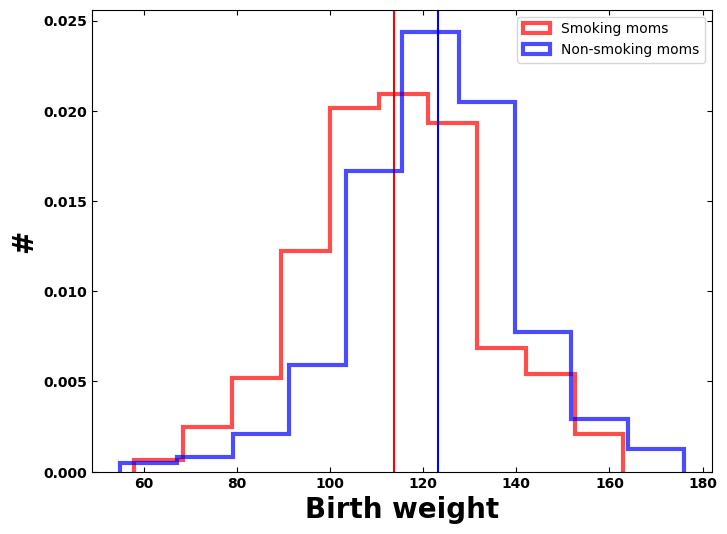

In [88]:
fig, ax1 = plt.subplots(figsize=(8,6), facecolor='w', edgecolor='k')

# Horizontal Bar Plot
ax1.hist(smoking_and_birthweight[smoking_and_birthweight['Maternal Smoker']==True]['Birth Weight'].values,histtype='step',density=True,color='r', alpha=0.7,lw=3,label='Smoking moms')
ax1.axvline(x=smoking_and_birthweight[smoking_and_birthweight['Maternal Smoker']==True]['Birth Weight'].mean(),color='r')

ax1.hist(smoking_and_birthweight[smoking_and_birthweight['Maternal Smoker']==False]['Birth Weight'].values,histtype='step',density=True,color='b', alpha=0.7,lw=3,label='Non-smoking moms')
ax1.axvline(x=smoking_and_birthweight[smoking_and_birthweight['Maternal Smoker']==False]['Birth Weight'].mean(),color='b')


ax1.set_ylabel('#',fontsize=20,fontweight='bold')
ax1.set_xlabel('Birth weight',fontsize=20,fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=10,direction='in',right='on',top='on')
ax1.legend()
ax = plt.gca()
for tick in ax.get_xticklabels():
    tick.set_fontweight('bold')
for tick in ax.get_yticklabels():
    tick.set_fontweight('bold')
plt.show()

### First make hypothesis

**Null hypothesis**: is the one that states that sample observations result purely from chance. From an A/B test perspective, the null hypothesis states that there is no difference between the control and variant groups. It states the default position to be tested or the situation as it is now, i.e. the status quo.

HERE: In the population, the distribution of birth weights of babies is the same for mothers who don’t smoke as for mothers who do. The difference in the sample is due to chance.

**Alternative hypothesis**: The alternative hypothesis challenges the null hypothesis and is basically a hypothesis that the researcher believes to be true. The alternative hypothesis is what you might hope that your A/B test will prove to be true.

HERE: In the population, the babies of the mothers who smoke have a lower birth weight, on average, than the babies of the non-smokers.




**H0** μ1=μ2

**H1** μ1≠μ2

# Test Statistic

[Question] What values of our statistic are in favor of the alternative: positive or negative?

In [135]:
means_table = smoking_and_birthweight.groupby('Maternal Smoker').mean()
means_table

,Birth Weight
Maternal Smoker,
False,123.085315
True,113.819172


In [136]:
means = means_table["Birth Weight"]
observed_difference = means.iloc[1] - means.iloc[0]
observed_difference

-9.266142572024918

In [34]:
def difference_of_means(table, label, group_label):
    reduced = table[[label, group_label]]
    means_table = reduced.groupby(group_label).mean()
    means = means_table[label]
    return means.iloc[1] - means.iloc[0]

In [138]:
difference_of_means(births, 'Birth Weight', 'Maternal Smoker')

-9.266142572024918

### Predicting the Statistic Under Null Hypothesis

In [139]:
smoking_and_birthweight

,Maternal Smoker,Birth Weight
0,False,120
1,False,113
2,True,128
3,True,108
4,False,136
...,...,...
1169,False,113
1170,False,128
1171,True,130
1172,False,125


In [140]:
shuffled_labels = smoking_and_birthweight.sample(frac=1, replace=False, ignore_index=True)["Maternal Smoker"]
original_and_shuffled = smoking_and_birthweight.copy()
original_and_shuffled['Shuffled Label'] = shuffled_labels

In [141]:
original_and_shuffled

,Maternal Smoker,Birth Weight,Shuffled Label
0,False,120,True
1,False,113,True
2,True,128,True
3,True,108,False
4,False,136,True
...,...,...,...
1169,False,113,True
1170,False,128,True
1171,True,130,False
1172,False,125,False


In [142]:
shuffled_only = original_and_shuffled.drop('Maternal Smoker', axis=1)
shuffled_group_means = shuffled_only.groupby('Shuffled Label').mean()
shuffled_group_means

,Birth Weight
Shuffled Label,
False,119.976224
True,118.662309


In [143]:
difference_of_means(original_and_shuffled, 'Birth Weight', 'Shuffled Label')


-1.313914408032062

In [35]:
def one_simulated_difference(table, label, group_label):
    shuffled_labels = table.sample(frac=1, replace=False, ignore_index=True)[group_label]
    shuffled_table = pd.DataFrame()
    shuffled_table[label] = table[label]
    shuffled_table['Shuffled Label'] = shuffled_labels
    return difference_of_means(shuffled_table, label, 'Shuffled Label') 

In [145]:
one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')

-0.33374773374774236

### Permutation Test

In [146]:
differences = np.array([])

for i in np.arange(2500):
    new_difference = one_simulated_difference(births, 'Birth Weight', 'Maternal Smoker')
    differences = np.append(differences, new_difference)

### Conclusion of the Test


Observed Difference: -9.266142572024918


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

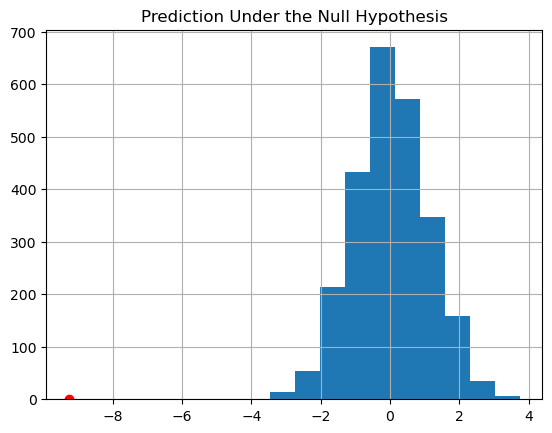

In [101]:
df = pd.DataFrame()
df['Difference Between Group Means'] = differences
df.hist()
print('Observed Difference:', observed_difference)
plt.plot(observed_difference, 0, 'ro')                 # Additional point

plt.title('Prediction Under the Null Hypothesis')

In [102]:

# Empirical P-value
empirical_P = np.count_nonzero(differences <= observed_difference) / len(differences)
empirical_P
# 0.0

0.0

## Using Z-test (N>30 and Gaussian distrubution)

***Null hypothesis:*** There is no difference between the two sample means (difference=0)

***Alternative hypothesis:*** There is a difference between the two sample means (two-tailed)

To understand this, we must be familiar with a few terms:

***Significance level (alpha):*** The significance level, also denoted as alpha or α, is the probability of rejecting the null hypothesis when it is true. Generally, we use the significance value of 0.05
    
***P-Value:*** It is the probability that the difference between the two values is just because of random chance. P-value is evidence against the null hypothesis. The smaller the p-value stronger the chances to reject the H0. For the significance level of 0.05, if the p-value is lesser than it hence we can reject the null hypothesis
    
***Confidence interval:*** The confidence interval is an observed range in which a given percentage of test outcomes fall. We manually select our desired confidence level at the beginning of our test. Generally, we take a 95% confidence interval

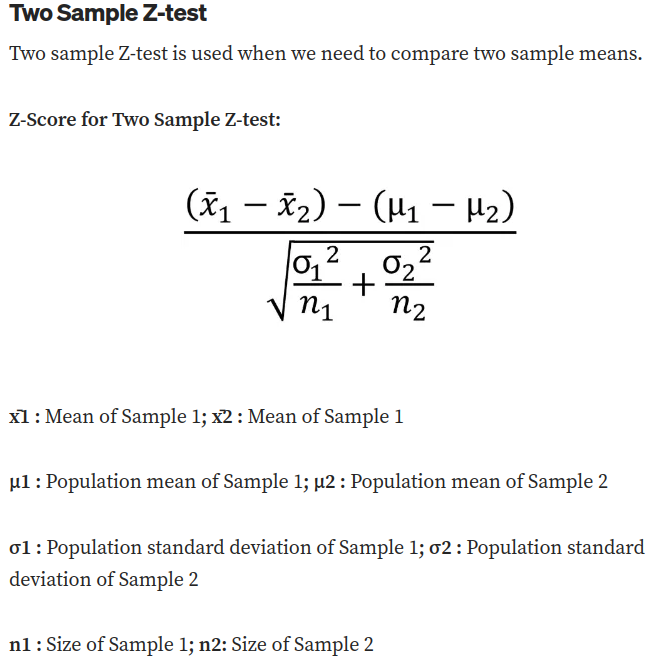

In [152]:
import scipy.stats as stats
from scipy.stats import norm


smoke=smoking_and_birthweight[smoking_and_birthweight['Maternal Smoker']==True]['Birth Weight'].values
nonsmoke=smoking_and_birthweight[smoking_and_birthweight['Maternal Smoker']==False]['Birth Weight'].values
# calculate means
x1, x2 = np.mean(smoke), np.mean(nonsmoke)
# calculate standard errors
std1, std2 = np.std(smoke), np.std(nonsmoke)
# size sample
n1,n2=np.size(smoke),np.size(nonsmoke)


# Null Hypothesis = mu_1-mu_2 = 0 
# Hypothesized difference (under the null hypothesis)
D = 0
 
# Set the significance level
alpha = 0.05
 
# Calculate the test statistic (z-score)
z_score = ((x1 - x2) - D) / np.sqrt((std1**2 / n1) + (std2**2 / n2))
print('Z-Score:', np.abs(z_score))
 
# Calculate the critical value
z_critical = stats.norm.ppf(1 - alpha/2) #(alpha/2 because two sides)
print('Critical Z-Score:',z_critical)
 
# Compare the test statistic with the critical value
if np.abs(z_score) > z_critical:
    print("""Reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.""")
else:
    print("""Fail to reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.""")
 
# Approach 2: Using P-value
     
# P-Value : Probability of getting less than a Z-score
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))
print('P-Value :',p_value)
 
# Compare the p-value with the significance level
if p_value < alpha:
    print("""Reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.""")
else:
    print("""Fail to reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.""")


Z-Score: 8.634634929032464
Critical Z-Score: 1.959963984540054
Reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.
P-Value : 0.0
Reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.


**using sm.stats**

In [151]:
sm.stats.ztest(nonsmoke, smoke,alternative='two-sided')


(8.718755502379533, 2.812762148971705e-18)

Since the p-value (2.89e-18) is extremely small, we can reject the Null hypothesis that the mean baby weigth of smokier is same as that of non smoker moms. Note, we used alternative="two-sided" in the z-test because here we are checking for inequality.

### KOLMOGOROV-SMIRNOV TEST

***Null hypothesis:*** The two samples being compared are drawn from the same underlying probability distribution

***Alternative hypothesis:*** They are drawn from different distributions. 

Test statistic: 0.23554092965857673
P-value: 4.218576419218256e-14
Reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.


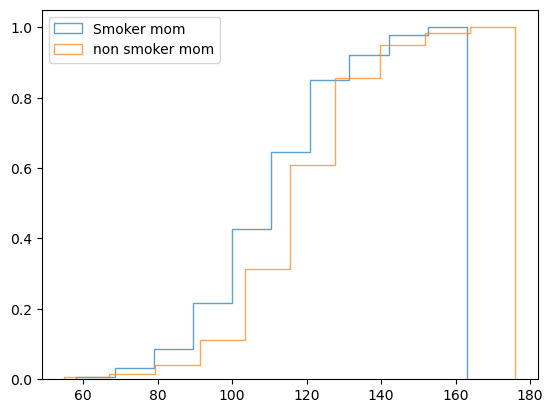

In [104]:
from scipy.stats import ks_2samp


# Perform two-sample KS test
statistic, p_value = ks_2samp(smoke, nonsmoke)
print('Test statistic:', statistic)
print('P-value:', p_value)
 
 
# Compare the p-value with the significance level
if p_value < alpha:
    print("""Reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.""")
else:
    print("""Fail to reject the null hypothesis.
There is a significant difference between the baby weight for smoker and non smoker mom.""")

# Visualize the two samples and the test statistic
fig, ax = plt.subplots()
ax.hist(smoke, alpha=0.7, density=True, histtype="step",cumulative=True, label="Smoker mom")
ax.hist(nonsmoke, alpha=0.7, density=True, histtype="step",cumulative=True, label="non smoker mom")
ax.legend(loc=2)
plt.show()

# One Population Mean

In [156]:
Adult_weight=np.array([80.57, 98.96, 85.28, 83.83, 69.94, 89.59, 91.09, 66.25, 91.21, 82.7 , 73.54, 81.99, 54.01, 82.89, 75.88, 98.32, 107.2 , 85.53, 79.08, 84.3 , 89.32, 86.35, 78.98, 92.26, 87.01])
Adult_weight

array([ 80.57,  98.96,  85.28,  83.83,  69.94,  89.59,  91.09,  66.25,
        91.21,  82.7 ,  73.54,  81.99,  54.01,  82.89,  75.88,  98.32,
       107.2 ,  85.53,  79.08,  84.3 ,  89.32,  86.35,  78.98,  92.26,
        87.01])

**Question**: Is the average weight (in kg) for adults more than 80 kg?

**Null Hypothesis (H0)**: μ= 80

**Alternative Hypthosis (H1)**: μ> 80

In [159]:
print('average adult weight: %0.2f'%np.mean(Adult_weight))
print('std adult weight: %0.2f'%np.std(Adult_weight))

average adult weight: 83.84
std adult weight: 10.72


In [160]:
sm.stats.ztest(Adult_weight, value = 80, alternative = "larger")

(1.756973189172546, 0.039461189601168366)


**Conclusion of the hypothesis test**

Since the p-value (0.0394) is lower than the standard confidence level 0.05, we can reject the Null hypothesis that the mean weight for adults is equal to 80 kg. There is strong evidence in support for the alternatine hypothesis that the mean is higher than 80 kg. Note, we used alternative="larger" in the z-test.

In [173]:
mu_bootstrap=[]
for i in range (5000):
    bootstrap = np.random.choice(Adult_size, size=len(Adult_size), replace=True)
    mu_bootstrap.append(np.mean(bootstrap))


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis, mu=80')

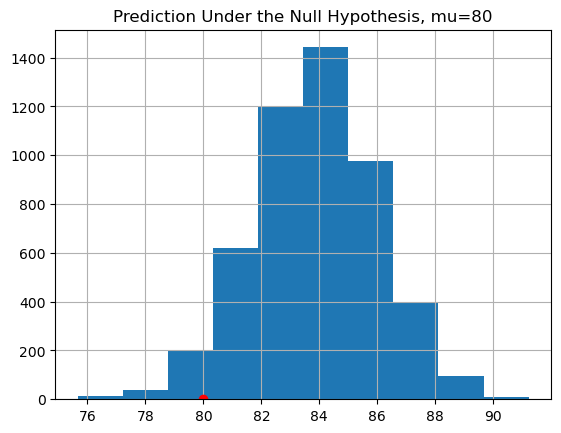

In [188]:
df = pd.DataFrame()
df['mu_bootstrap'] = np.array(mu_bootstrap)
df.hist()
plt.plot(80, 0, 'ro')                 # Additional point
#print('Observed Difference:', observed_diff)
plt.title('Prediction Under the Null Hypothesis, mu=80')

In [186]:
# Empirical P-value
empirical_P = np.count_nonzero(np.array(mu_bootstrap) <= 80) / len(mu_bootstrap)
empirical_P

if empirical_P<0.05:
    print('Reject the Null hypothesis that the mean weight for adults is equal to 80 kg.')

Reject the Null hypothesis that the mean weight for adults is equal to 80 kg.


# Random examples

In [107]:
bta = pd.read_csv('data/bta.csv')
bta

,Group,Result
0,Control,1.0
1,Control,1.0
2,Control,0.0
3,Control,0.0
4,Control,0.0
5,Control,0.0
6,Control,0.0
7,Control,0.0
8,Control,0.0
9,Control,0.0


In [108]:
bta.groupby('Group')['Result'].mean().reset_index(name='Result average')

,Group,Result average
0,Control,0.125
1,Treatment,0.600


In the treatment group, 60% of the patients had pain relief, compared to only 12.5% in the control group. None of the patients suffered any side effects.

So the indications are that botulinum toxin A did better than the saline. But the conclusion isn’t yet a slam-dunk. The patients were assigned at random into the two groups, so perhaps the difference could just be due to chance?

### Testing the Hypothesis

**Null Hypothesis:**  Botulinum toxin A does nothing different from saline; the difference in the two samples is just due to chance.

**Alternative Hypothesis:**  The treatment does something different from the control.

In [109]:
observed_diff = difference_of_means(bta, 'Result', 'Group')
observed_diff

0.475

In [110]:
one_simulated_difference(bta, 'Result', 'Group')

0.08750000000000002

In [111]:
simulated_diffs = np.array([])

for i in np.arange(10000):
    sim_diff = one_simulated_difference(bta, 'Result', 'Group')
    simulated_diffs = np.append(simulated_diffs, sim_diff)

Observed Difference: 0.475


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

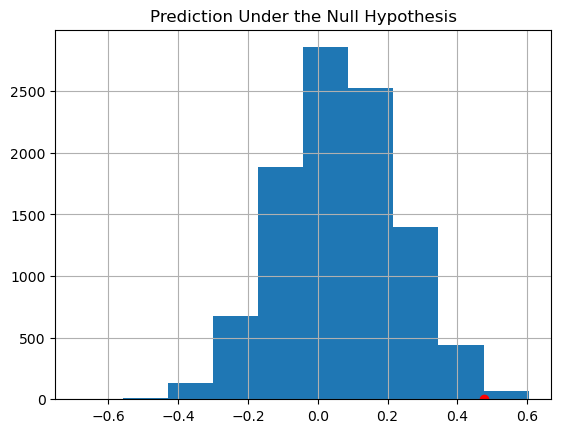

In [112]:
df = pd.DataFrame()
df['Difference Between Group Means'] = simulated_diffs
df.hist()
plt.plot(observed_diff, 0, 'ro')                 # Additional point
print('Observed Difference:', observed_diff)
plt.title('Prediction Under the Null Hypothesis')

In [117]:
# p-value
pval=sum(simulated_diffs >= observed_diff)/len(simulated_diffs)
pval

0.0069

In [118]:
if pval<0.05:
    print('This is a small P-value. The observed statistic is in the tail of the empirical histogram of the test statistic generated under the null hypothesis.')

    print('The result is statistically significant. The test favors the alternative hypothesis over the null. The evidence supports the hypothesis that the treatment is doing something.')

This is a small P-value. The observed statistic is in the tail of the empirical histogram of the test statistic generated under the null hypothesis.
The result is statistically significant. The test favors the alternative hypothesis over the null. The evidence supports the hypothesis that the treatment is doing something.


In [119]:
data1=bta[bta['Group']=='Control'].Result
data2=bta[bta['Group']=='Treatment'].Result
def statistic(x, y, axis):
    return np.mean(x, axis=axis) - np.mean(y, axis=axis)
from scipy.stats import permutation_test
# because our statistic is vectorized, we pass `vectorized=True`
# `n_resamples=np.inf` indicates that an exact test is to be performed
res = permutation_test((data1, data2), statistic, vectorized=True,n_resamples=10000, alternative='less')
print(res.statistic)
print(res.pvalue)


-0.475
0.008399160083991601


### Student’s t-Test (N<30 and t distrubution)

In [122]:
# t-test for independent samples
from scipy.stats import t

data1=bta[bta['Group']=='Control'].Result
data2=bta[bta['Group']=='Treatment'].Result


# calculate means
x1, x2 = np.mean(data1), np.mean(data2)
# calculate standard errors
std1, std2 = np.std(data1), np.std(data2)
# size sample
n1,n2=np.size(data1),np.size(data2)
se1, se2 = std1/np.sqrt(n1), std2/np.sqrt(n2)
# standard error on the difference between the samples
sed = np.sqrt(se1**2.0 + se2**2.0)
# calculate the t statistic
t_stat = (x1 - x2) / sed
# degrees of freedom
df = len(data1) + len(data2) - 2
# calculate the critical value
cv = t.ppf(1.0 - alpha, df)
# calculate the p-value
p = (1.0 - t.cdf(abs(t_stat), df)) * 2.0
 

#using stat
t_direct,p_direct=stats.ttest_ind(data1, data2)
    
    
print('t=%.3f, df=%d, cv=%.3f, p=%.3f, alpha=%.3f' % (t_stat, df, cv, p, alpha))
print('t_direct=%.3f, p_direct=%.3f' % (t_direct,p_direct))

# interpret via critical value
if abs(t_stat) <= cv:
 print('Accept null hypothesis that the means are equal, treatment does not work.')
else:
 print('Reject the null hypothesis that the means are equal, treatment works')
# interpret via p-value
if p > alpha:
 print('Accept null hypothesis that the means are equal, treatment does not work.')
else:
 print('Reject the null hypothesis that the means are equal, treatment works.')


t=-3.143, df=29, cv=1.699, p=0.004, alpha=0.050
t_direct=-3.077, p_direct=0.005
Reject the null hypothesis that the means are equal, treatment works
Reject the null hypothesis that the means are equal, treatment works.


## sleep survey

In [123]:
survey = pd.read_csv('data/welcome_survey_v4.csv')
survey

,Year,Extraversion,Number of textees,Hours of sleep,Handedness,Sleep position
0,Second,6,10,7.0,Right-handed,On your back
1,Fourth or above,9,25,7.0,Right-handed,On your left side
2,First,7,5,8.0,Right-handed,On your stomach
3,Second,5,6,8.0,Right-handed,On your right side
4,Second,5,10,7.0,Right-handed,On your right side
...,...,...,...,...,...,...
1317,Fourth or above,9,10,8.0,Right-handed,On your stomach
1318,Fourth or above,9,3,7.0,Right-handed,On your right side
1319,Second,4,6,7.0,Left-handed,On your left side
1320,Second,6,3,8.0,Right-handed,On your left side


In [124]:
def simplify(position):
    if position == 'On your left side' or position == 'On your right side':
        return 'side'
    else:
        return 'back or stomach'

survey['Position']=survey['Sleep position'].apply(simplify) 
survey



,Year,Extraversion,Number of textees,Hours of sleep,Handedness,Sleep position,Position
0,Second,6,10,7.0,Right-handed,On your back,back or stomach
1,Fourth or above,9,25,7.0,Right-handed,On your left side,side
2,First,7,5,8.0,Right-handed,On your stomach,back or stomach
3,Second,5,6,8.0,Right-handed,On your right side,side
4,Second,5,10,7.0,Right-handed,On your right side,side
...,...,...,...,...,...,...,...
1317,Fourth or above,9,10,8.0,Right-handed,On your stomach,back or stomach
1318,Fourth or above,9,3,7.0,Right-handed,On your right side,side
1319,Second,4,6,7.0,Left-handed,On your left side,side
1320,Second,6,3,8.0,Right-handed,On your left side,side


In [125]:
means_table = survey.groupby('Position')['Hours of sleep'].mean()
means_table

Position
back or stomach    7.127918
side               7.032797
Name: Hours of sleep, dtype: float64

**Null Hypothesis:**  In average people sleeping on the side have the same hours of sleep

**Alternative Hypothesis:**  Difference between side and back/stomach

In [126]:
observed_difference = means_table.iloc[1] - means_table.iloc[0]
observed_difference

-0.09512125823477291

In [127]:
one_simulated_difference(survey, 'Hours of sleep', 'Position')

0.03618364025118481

In [128]:
simulated_diffs = np.array([])

for i in np.arange(5000):
    sim_diff = one_simulated_difference(survey, 'Hours of sleep', 'Position')
    simulated_diffs = np.append(simulated_diffs, sim_diff)

Observed Difference: -0.09512125823477291


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

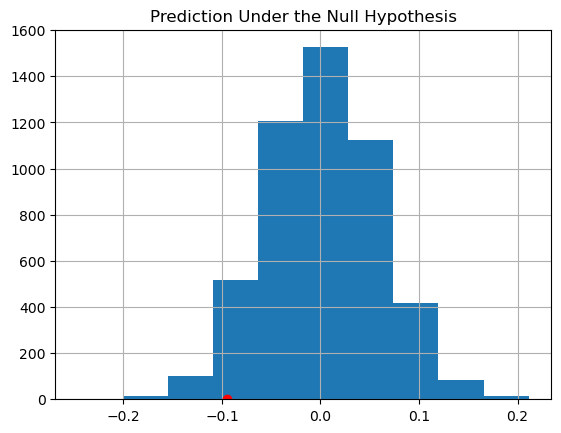

In [129]:
df = pd.DataFrame()
df['Difference Between Group Means'] = simulated_diffs
df.hist()
print('Observed Difference:', observed_difference)
plt.plot(observed_difference, 0, 'ro')                 # Additional point
plt.title('Prediction Under the Null Hypothesis')

In [130]:
# p-value
sum(simulated_diffs <= observed_difference)/len(simulated_diffs)

0.0432

In [131]:

side=survey[survey['Position']=='side']['Hours of sleep'].values
back=survey[survey['Position']=='back or stomach']['Hours of sleep'].values
# calculate means
x1, x2 = np.mean(side), np.mean(back)
# calculate standard errors
std1, std2 = np.std(side), np.std(back)
# size sample
n1,n2=np.size(side),np.size(back)


# Null Hypothesis = mu_1-mu_2 = 0 
# Hypothesized difference (under the null hypothesis)
D = 0
 
# Set the significance level
alpha = 0.05
 
# Calculate the test statistic (z-score)
z_score = ((x1 - x2) - D) / np.sqrt((std1**2 / n1) + (std2**2 / n2))
print('Z-Score:', np.abs(z_score))
 
# Calculate the critical value
z_critical = stats.norm.ppf(1 - alpha/2)
print('Critical Z-Score:',z_critical)
 
 
# Compare the test statistic with the critical value
if np.abs(z_score) > z_critical:
    print("""Reject the null hypothesis.
There is a significant difference between the two positions.""")
else:
    print("""Fail to reject the null hypothesis.
There is not enough evidence to suggest a significant difference between the two positions.""")
 
# Approach 2: Using P-value
     
# P-Value : Probability of getting less than a Z-score
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))
print('P-Value :',p_value)
 
# Compare the p-value with the significance level
if p_value < alpha:
    print("""Reject the null hypothesis.
There is a significant difference between the two positions.""")
else:
    print("""Fail to reject the null hypothesis.
There is a significant difference between the two positions.""")


Z-Score: 1.6821667930572257
Critical Z-Score: 1.959963984540054
Fail to reject the null hypothesis.
There is not enough evidence to suggest a significant difference between the two positions.
P-Value : 0.09253650135698965
Fail to reject the null hypothesis.
There is a significant difference between the two positions.


## E-Commerce A/B

### Designing our experiment

The dataset contains 5 columns , 294478 records:

-> user_id: unique id of the user who came to the website

-> timestamp: timestamp that the user came to the page

-> group: whether the user in treatment group or control group

-> landing_page: whether the user saw the old page or new page

-> converted: whether the user converted to a paid user. 1 means converted, 0 means not converted.

**problem**:
The product manager (PM) told you that the current conversion rate is about 12% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 14%.

**Hypothesis**


Given we don't know if the new design will perform better or worse as our current design, we'll choose a two-tailed test:

**Null Hypothesis (H0): p=p0** where p,p0 stand for the conversion rate of the new and old design, respectively. 

**Alternative hypothesis (H1) p≠p0**, i.e; the old an new page do have the same conversion rate

**Confidence level** We want a confidence level of 95%, alpha=1-0.95=0.05

For our test we'll need two groups:

A control group - They'll be shown the old design
A treatment (or experimental) group - They'll be shown the new design

For our Dependent Variable we are interested in capturing the conversion rate.

0 - The user did not buy the product during this user session
1 - The user bought the product during this user session
This way, we can easily calculate the mean for each group to get the conversion rate of each design.

### Minimum size of sample to answer the question

In [30]:

effect_size =sm.stats.proportion_effectsize(0.12, 0.14)    # Calculating effect size based on our expected rates

required_n = sm.stats.NormalIndPower().solve_power(
    effect_size, 
    power=0.8, 
    alpha=0.05, 
    ratio=1
    )                                                  # Calculating sample size needed
print('You need at least %s'%round(required_n))


You need at least 4432


### Data cleaning

In [4]:
df = pd.read_csv('data/ab_data.csv')

df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [5]:
#Check duplicate
print('There are %s duplicates in columns user_id for a total of %s rows'%(sum(df.duplicated(subset=['user_id'])),df.shape[0]))

There are 3894 duplicates in columns user_id for a total of 294478 rows


In [6]:
df=df[~df.duplicated(subset=['user_id'])]
df

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
...,...,...,...,...,...
294473,751197,2017-01-03 22:28:38.630509,control,old_page,0
294474,945152,2017-01-12 00:51:57.078372,control,old_page,0
294475,734608,2017-01-22 11:45:03.439544,control,old_page,0
294476,697314,2017-01-15 01:20:28.957438,control,old_page,0


In [7]:
df=df[['group','landing_page','converted']]
df.info()


<class 'pandas.core.frame.DataFrame'>
Index: 290584 entries, 0 to 294477
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   group         290584 non-null  object
 1   landing_page  290584 non-null  object
 2   converted     290584 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 8.9+ MB


In [8]:
# To make sure all the control group are seeing the old page and viceversa

pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,1006,144226
treatment,144314,1038


In [9]:
# Check size of both group
print('size group control: %s'%len(df[df.group=='control']))
print('size group treatment: %s'%len(df[df.group=='treatment']))

print('It is almost the same')

size group control: 145232
size group treatment: 145352
It is almost the same


In [10]:
# We select only old page for the con
df =df.drop(df[(df.landing_page == "new_page") & (df.group == "control")].index)
df =df.drop(df[(df.landing_page == "old_page") & (df.group == "treatment")].index)
pd.crosstab(df['group'], df['landing_page'])

landing_page,new_page,old_page
group,,
control,0,144226
treatment,144314,0


In [11]:
conversion_rates = df.groupby('group')['converted'].agg(['mean', np.std])
conversion_rates

/tmp/ipykernel_837330/2329567543.py:1: FutureWarning: The provided callable <function std at 0x7f539c30fce0> is currently using SeriesGroupBy.std. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "std" instead.
  conversion_rates = df.groupby('group')['converted'].agg(['mean', np.std])


,mean,std
group,,
control,0.120290,0.325302
treatment,0.118727,0.323468


Judging by the stats above, it does look like our two designs performed very similarly, with our old design performing slightly better

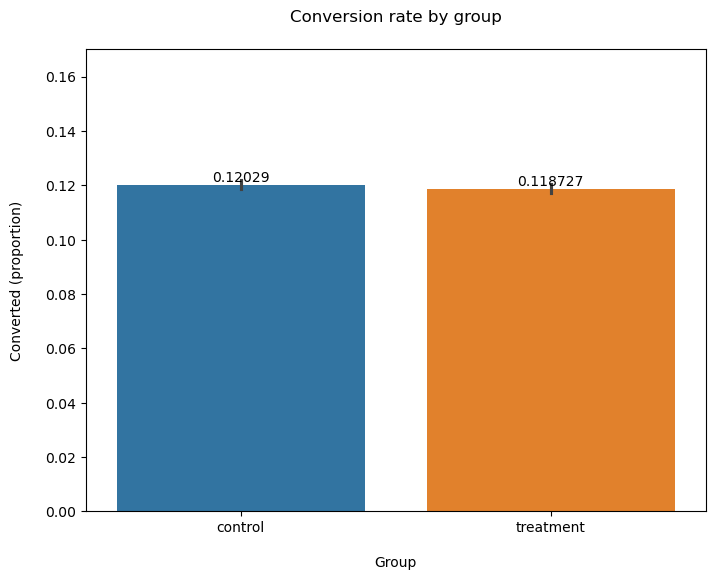

In [19]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(8,6), facecolor='w', edgecolor='k')

sns.barplot(x=df['group'], y=df['converted'],hue=df['group'])
plt.ylim(0, 0.17)
plt.title('Conversion rate by group', pad=20)
plt.xlabel('Group', labelpad=15)
plt.ylabel('Converted (proportion)', labelpad=15)
for i in ax.containers:
    ax.bar_label(i,)

### Testing hypothesis

In [25]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']

n_con = control_results.count()
n_treat = treatment_results.count()
successes = [control_results.sum(), treatment_results.sum()]
nobs = [n_con, n_treat]

print(successes,nobs)


[17349, 17134] [144226, 144314]


In [29]:
z_stat, pval = proportions_ztest(successes, nobs=nobs)
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f'z statistic: {z_stat:.2f}')
print(f'p-value: {pval:.3f}')
print(f'ci 95% for control group: [{lower_con:.3f}, {upper_con:.3f}]')
print(f'ci 95% for treatment group: [{lower_treat:.3f}, {upper_treat:.3f}]')


z statistic: 1.29
p-value: 0.196
ci 95% for control group: [0.119, 0.122]
ci 95% for treatment group: [0.117, 0.120]


Since our p-value=0.196 is way above our alpha=0.05, we cannot reject the null hypothesis: our new design did not perform significantly different than our old one.

Additionally, if we look at the confidence interval for the treatment group ([0.117, 0.12]) we notice that:

    It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for.

In [32]:
import scipy.stats as stats
from scipy.stats import norm


control_results = df[df['group'] == 'control']['converted']
treatment_results = df[df['group'] == 'treatment']['converted']
# calculate means
x1, x2 = np.mean(control_results ), np.mean(treatment_results )
# calculate standard errors
std1, std2 = np.std(control_results ), np.std(treatment_results )
# size sample
n1,n2=np.size(control_results ),np.size(treatment_results )


# Null Hypothesis = mu_1-mu_2 = 0 
# Hypothesized difference (under the null hypothesis)
D = 0
 
# Set the significance level
alpha = 0.05
 
# Calculate the test statistic (z-score)
z_score = ((x1 - x2) - D) / np.sqrt((std1**2 / n1) + (std2**2 / n2))
print('Z-Score:', np.abs(z_score))
 
# Calculate the critical value
z_critical = stats.norm.ppf(1 - alpha/2) #(alpha/2 because two sides)
print('Critical Z-Score:',z_critical)
 
# Compare the test statistic with the critical value
if np.abs(z_score) > z_critical:
    print("""Reject the null hypothesis.
There is a significant difference between the 2 webpage.""")
else:
    print("""Fail to reject the null hypothesis.
There is not a significant difference between the 2 webpage.""")
 
# Approach 2: Using P-value
     
# P-Value : Probability of getting less than a Z-score
p_value = 2 * (1 - stats.norm.cdf(np.abs(z_score)))
print('P-Value :',p_value)
 
# Compare the p-value with the significance level
if p_value < alpha:
    print("""Reject the null hypothesis.
There is a significant difference between the 2 webpage.""")
else:
    print("""Fail to reject the null hypothesis.
There is not a significant difference between the 2 webpage.""")


Z-Score: 1.294238314737139
Critical Z-Score: 1.959963984540054
Fail to reject the null hypothesis.
There is not a significant difference between the 2 webpage.
P-Value : 0.19558311606977163
Fail to reject the null hypothesis.
There is not a significant difference between the 2 webpage.


In [36]:
differences = np.array([])

for i in np.arange(2500):
    new_difference = one_simulated_difference(df, 'converted', 'group')
    differences = np.append(differences, new_difference)



95% Confidence interval: [-0.2294206   0.22496877]
Observed Difference: -0.15631577894657384


Text(0.5, 1.0, 'Prediction Under the Null Hypothesis')

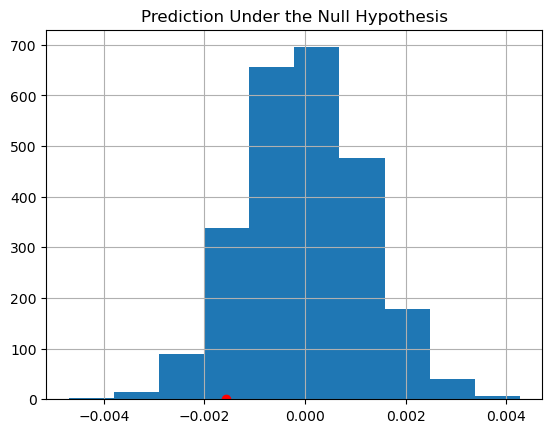

In [44]:
confidence_interval = np.percentile(differences, [2.5, 97.5])
print("95% Confidence interval:", confidence_interval*100)    

observed_difference=difference_of_means(df, 'converted', 'group')
df2 = pd.DataFrame()
df2['Difference Between Group Means'] = differences
df2.hist()
print('Observed Difference:', observed_difference*100)
plt.plot(observed_difference, 0, 'ro')                 # Additional point

plt.title('Prediction Under the Null Hypothesis')


In [45]:
# Empirical P-value
empirical_P = np.count_nonzero(differences <= observed_difference) / len(differences)
empirical_P

0.096

# Bootstrap Sampling for Confidence Intervals

In [134]:


ages = np.array([25, 30, 35, 40, 45, 50, 55, 60, 65, 70])
 
num_samples = 1000
 
bootstrap_means = np.zeros(num_samples)
 
# Perform bootstrap sampling
for i in range(num_samples):
 
    bootstrap_sample = np.random.choice(ages, size=len(ages), replace=True)
    bootstrap_mean = np.mean(bootstrap_sample)
    bootstrap_means[i] = bootstrap_mean
    

 
confidence_interval = np.percentile(bootstrap_means, [2.5, 97.5])
 
print("95% Confidence interval:", confidence_interval)    
 
estimated_mean = np.mean(bootstrap_means)
estimated_std = np.std(bootstrap_means, ddof=1)
 
print("mean age:", np.mean(ages))
print("Estimated population mean age:", estimated_mean)
print("Standard error of the estimate:", estimated_std)

95% Confidence interval: [39.5 56. ]
mean age: 47.5
Estimated population mean age: 47.573
Standard error of the estimate: 4.37393441906738


# Two-Sample Bootstrap Hypothesis Test



We perform a two-sample bootstrap hypothesis test to determine whether there is a significant difference between the means of two independent groups

In [109]:
import numpy as np
 
group1 = [10, 12, 15, 18, 20]
group2 = [8, 11, 13, 16, 19]
 
num_samples = 1000
 
bootstrap_diffs = np.zeros(num_samples)
 
# Perform bootstrap sampling
for i in range(num_samples):
    bootstrap_group1 = np.random.choice(group1, size=len(group1), replace=True)
    bootstrap_group2 = np.random.choice(group2, size=len(group2), replace=True)
     
    bootstrap_diff = np.mean(bootstrap_group1) - np.mean(bootstrap_group2)
    bootstrap_diffs[i] = bootstrap_diff
 
p_value = np.mean(bootstrap_diffs >= np.mean(group1) - np.mean(group2))
 
print("Bootstrap p-value:", p_value)

Bootstrap p-value: 0.505
